In [1]:
# All imports/seeds
import train_reconstruction_embedding
import train_classification_model
import logging as log
import argparse
import torch
import matplotlib
import torch.nn.functional as F
from torchmetrics.functional import accuracy, f1_score as f1
import lightning.pytorch as pl
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image
from dataloader.asimow_dataloader import DataSplitId, ASIMoWDataModule
from utils import get_latent_dataloader, print_training_input_shape
from model.mlp import MLP
from dataloader.utils import get_val_test_ids
from personal_utils import  (get_models_and_files, get_dataloaders_and_datasets,
                             get_embedding_files, send_through_model, send_through_patch_model,
                             send_through_decoder, generate_saliency_map, plot_saliency_map, alter_q_data, plot_reconstruction_difference)
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [2]:
my_trained_mlp, model, codebook, complete_q_tensor, complete_q_indices, my_hparams = get_models_and_files(mode = "VQ-VAE")
my_trained_mlp_patch, model_patch, codebook_patch, complete_q_tensor_patch, complete_q_indices_patch, my_hparams_patch = get_models_and_files(mode = "VQ-VAE-Patch")
my_trained_mlp_yannik_patch, model_yannik_patch, codebook_yannik_patch, complete_q_tensor_yannik_patch, complete_q_indices_yannik_patch, my_hparams_y_patch = get_models_and_files(mode = "VQ-VAE-Yannik-Patch")

_, _, _, train_data, val_data, test_data, train_labels, val_labels, test_labels = get_dataloaders_and_datasets()
# _, _, complete_sm, complete_sm_bad, complete_sm_embed_mean, complete_sm_embed_mean_bad, complete_sm_dim_mean, complete_sm_dim_mean_bad = get_embedding_files()

model exists, no download needed
{'logger': <lightning.pytorch.loggers.csv_logs.CSVLogger object at 0x7fe385972d10>, 'hidden_dim': 32, 'input_dim': 2, 'num_embeddings': 256, 'embedding_dim': 32, 'n_resblocks': 1, 'learning_rate': 0.001, 'seq_len': 200, 'dropout_p': 0.1, 'decoder_type': 'Conv'}
model exists, no download needed
{'hidden_dim': 256, 'input_dim': 2, 'num_embeddings': 256, 'embedding_dim': 32, 'n_resblocks': 8, 'learning_rate': 0.001, 'seq_len': 200, 'dropout_p': 0.1, 'patch_size': 25, 'batch_norm': False, 'beta': 0.25, 'use_improved_vq': None, 'kmeans_iters': 10, 'threshold_ema_dead_code': 2}
model exists, no download needed
{'hidden_dim': 256, 'input_dim': 2, 'num_embeddings': 256, 'embedding_dim': 32, 'n_resblocks': 8, 'learning_rate': 0.001, 'seq_len': 200, 'dropout_p': 0.1, 'patch_size': 25, 'batch_norm': False, 'beta': 0.25}


In [3]:
print(my_hparams_patch)
print(my_hparams_y_patch)

{'hidden_dim': 128, 'input_dim': 2, 'num_embeddings': 128, 'embedding_dim': 16, 'n_resblocks': 16, 'learning_rate': 0.001, 'seq_len': 200, 'dropout_p': 0.1, 'patch_size': 25, 'batch_norm': False, 'beta': 0.25, 'use_improved_vq': True, 'kmeans_iters': 10, 'threshold_ema_dead_code': 2}
{'hidden_dim': 256, 'input_dim': 2, 'num_embeddings': 256, 'embedding_dim': 32, 'n_resblocks': 8, 'learning_rate': 0.001, 'seq_len': 200, 'dropout_p': 0.1, 'patch_size': 25, 'batch_norm': False, 'beta': 0.25}


In [3]:
torch.cuda.is_available()

True

In [5]:
data = torch.tensor(train_data[2])
type(data.unsqueeze(0))
# turn from Float to scalar type Double
data = torch.tensor(data.unsqueeze(0), dtype=torch.double)
data = torch.from_numpy(train_data[2]).float()
embedding_loss, x_hat, perplexity, z_q, q_indices, recon_error, loss = send_through_patch_model(model_patch, data.unsqueeze(0), reconstruct=True)
embedding_loss, x_hat, perplexity, z_q, q_indices, recon_error, loss = send_through_model(model, data.unsqueeze(0), reconstruct=True)

/tmp/ipykernel_27199/3872645302.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.unsqueeze(0), dtype=torch.double)


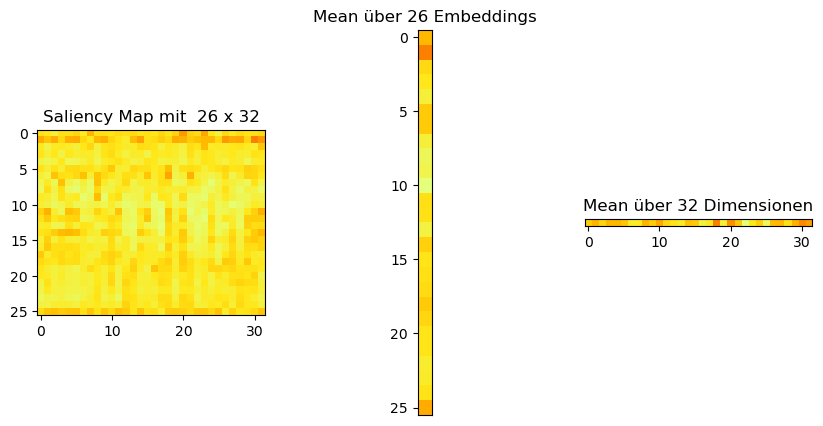

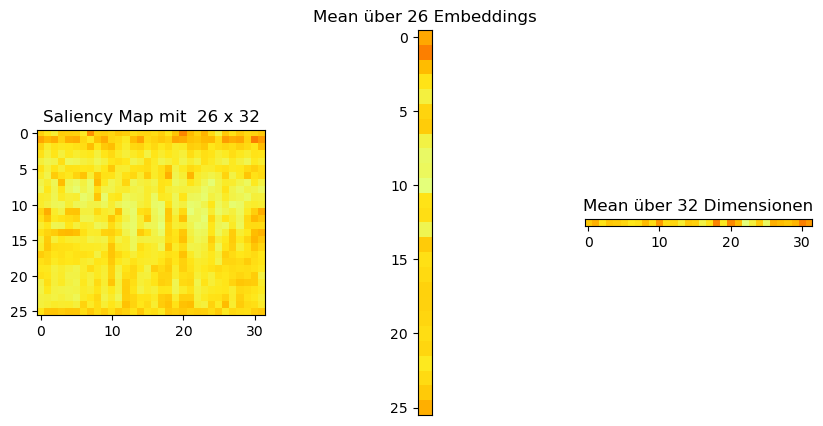

In [5]:
def create_mean_saliency_map(all_saliency_maps):
    mean_saliency_map = all_saliency_maps.mean(axis=0)
    return mean_saliency_map

mean_sm = create_mean_saliency_map(complete_sm)
mean_sm_bad = create_mean_saliency_map(complete_sm_bad)
plot_saliency_map([create_mean_saliency_map(complete_sm)], index=0, model=model)
plot_saliency_map([create_mean_saliency_map(complete_sm_bad)], index=0, model=model)

In [90]:
data = torch.from_numpy(train_data[3]).float()
embedding_loss, x_hat, perplexity, quantized_data, q_indices, recon_error, loss = send_through_model(model, data.unsqueeze(0), reconstruct=False)

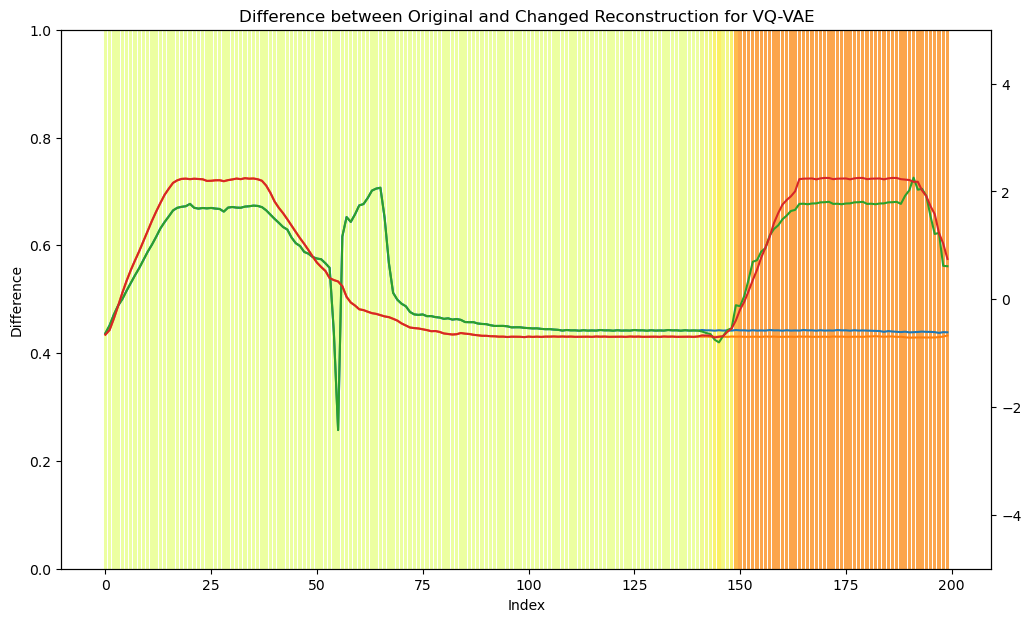

Q-Embeddings Indices:  [ 47  49 207 207 207 149 251  87  88 116 151 214 214 133 133 133 133 133
 133 133 133 133 133 133 133  98]


RuntimeError: The expanded size of the tensor (64) must match the existing size (16) at non-singleton dimension 0.  Target sizes: [64].  Tensor sizes: [16]

In [4]:
test_dpt = 3
original_data = torch.tensor(train_data[test_dpt])

alter_q_data(q_data=complete_q_tensor[test_dpt], original_data=original_data, alter_range = range(20, 26), alter_embedding = 207, model=model, label="VQ-VAE")
print("Q-Embeddings Indices: ", complete_q_indices[test_dpt])
alter_q_data(q_data=complete_q_tensor_patch[test_dpt], original_data=original_data, alter_range = range(12, 16), alter_embedding = 223, model=model_patch, label="VQ-VAE Patch")
print("Q-Embeddings Indices: ", complete_q_indices_patch[test_dpt])
alter_q_data(q_data=complete_q_tensor_yannik_patch[test_dpt], original_data=original_data, alter_range = range(12, 16), alter_embedding = 116, model=model_yannik_patch, label="Yannik VQ-VAE Patch")
print("Q-Embeddings Indices: ", complete_q_indices_yannik_patch[test_dpt])

tensor([[-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751],
        [-0.7378, -0.6751]])


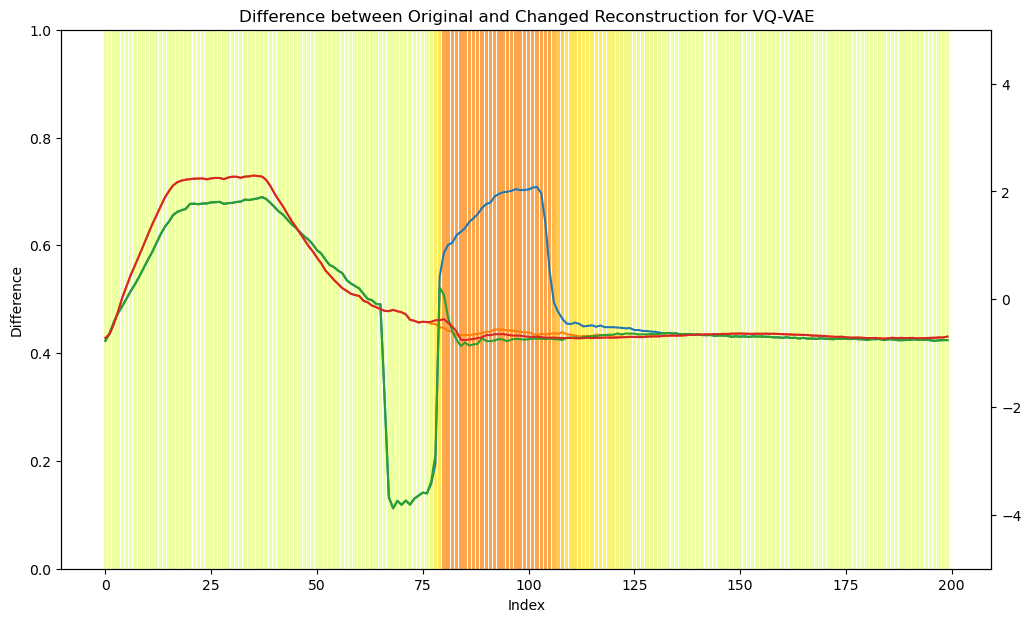

Q Indices before:  [228 154 207 207 207 207 124  22 144 229  85 231 225 116 116 214 133 133
  57  57  57  57 168 168 168  98]
Q Indices after:  [228 154 207 207 207 207 124  22 144 229  85 231  57 168 168 168 133 133
  57  57  57  57 168 168 168  98]
[ True  True  True  True  True  True  True  True  True  True  True  True
 False False False False  True  True  True  True  True  True  True  True
  True  True]


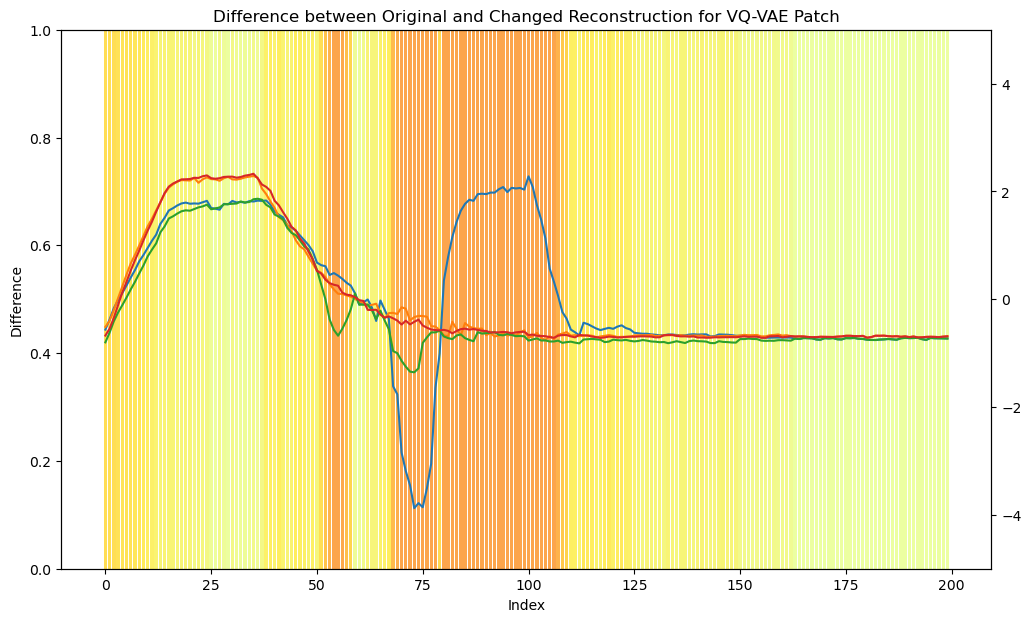

Q Indices before:  [225 197 217 252 106 217 217 217  32 197 177  80 217 217 217 217]
Q Indices after:  [225 197 217 217 217 217 217 217  32 197 177  80 217 217 217 217]
[ True  True  True False False  True  True  True  True  True  True  True
  True  True  True  True]


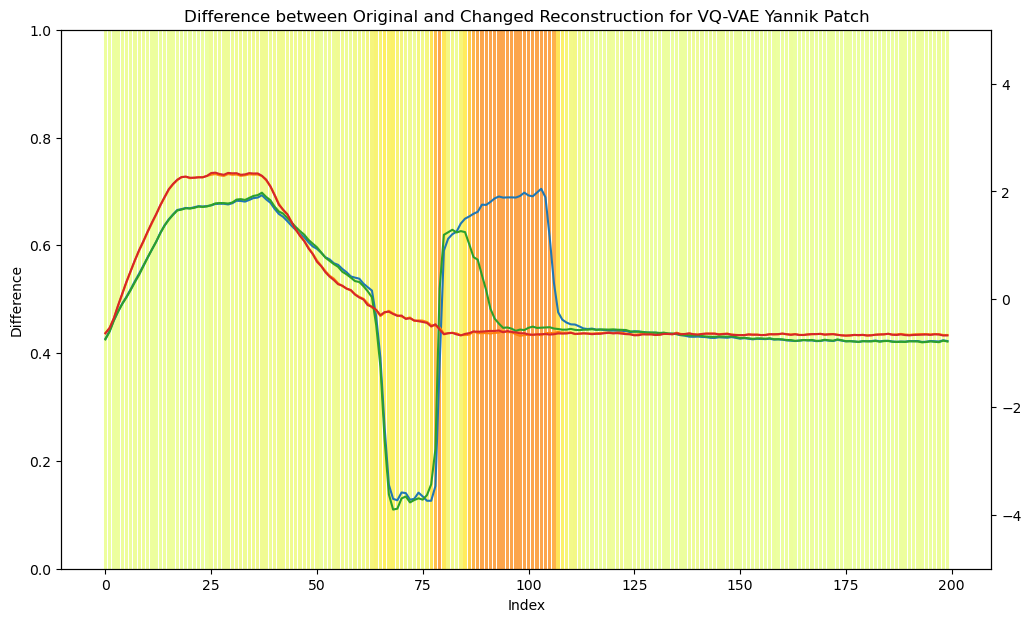

Q Indices before:  [243 135  12 193 234  88  27  27 135  50 222 162  27 183 183 183]
Q Indices after:  [243 135  12  12  27  88  27  27 135  50 222 111  27 183 183 183]
[ True  True  True False False  True  True  True  True  True  True False
  True  True  True  True]


In [7]:
def alter_input_data(original_data, alter_slice, alter_value, model, label, plot_altered=False):
    altered_input = original_data.clone()
    altered_input[alter_slice]=alter_value
    if label == "VQ-VAE":
        _, _, _, q_data, q_indices, _, _ = send_through_model(model, original_data.unsqueeze(0), reconstruct=False)
        _, _, _, changed_q_data, changed_q_indices, _, _ = send_through_model(model, altered_input.unsqueeze(0), reconstruct=False)
    else:
        _, _, _, q_data, q_indices, _, _ = send_through_patch_model(model, original_data.unsqueeze(0), reconstruct=False)
        _, _, _, changed_q_data, changed_q_indices, _, _ = send_through_patch_model(model, altered_input.unsqueeze(0), reconstruct=False)
    reconstructed_original, _= send_through_decoder(model=model, q_data=q_data, original_data = original_data, label=label)
    reconstructed_changed, _= send_through_decoder(model=model, q_data=changed_q_data, original_data = original_data, label=label)
    difference = plot_reconstruction_difference(reconstructed_original=reconstructed_original[0], reconstructed_changed=reconstructed_changed[0], original=altered_input, label=label, plot_original=plot_altered)
    print("Q Indices before: ", np.array(q_indices).reshape(q_indices.shape[0],))
    print("Q Indices after: ", np.array(changed_q_indices).reshape(q_indices.shape[0],))
    similarity = np.array(q_indices==changed_q_indices).reshape(q_indices.shape[0],)
    print(similarity)

test_dpt = 2
original_data = torch.from_numpy(train_data[test_dpt]).float()
print(original_data[-20:])
alter_input_data(original_data=original_data, alter_slice=slice(80,120), alter_value=-0.7, model=model, label="VQ-VAE", plot_altered=False)
alter_input_data(original_data=original_data, alter_slice=slice(80,120), alter_value=-0.7, model=model_patch, label="VQ-VAE Patch", plot_altered=False)
alter_input_data(original_data=original_data, alter_slice=slice(80,120), alter_value=-0.7, model=model_yannik_patch, label="VQ-VAE Yannik Patch", plot_altered=False)


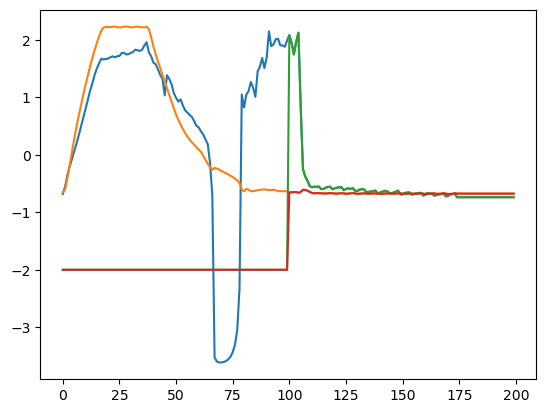

In [54]:
altered_input = original_data.clone()
# altered_input = original_data.permute(1,0)
# altered_input[0][0:10]=0.0
# altered_input[1][0:10]=0.0
# altered_input[0:10][:]=0.0
# altered_input[0:10][1]=0.0
# altered_input = altered_input.permute(1,0)
plt.plot(altered_input)

def slice_interval(interval):

    altered_input[interval]=-2.00
    plt.plot(altered_input)


slice_interval(slice(0, 100))

## REST


HTEST_1 VQ-VAE model_checkpoints/VQ-VAE/VQ-VAE-asimow-best-v7.ckpt
torch.Size([1, 832])


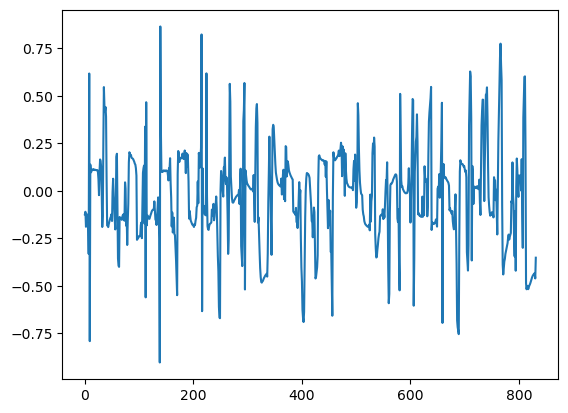

In [10]:
data_dict = get_val_test_ids()
val_ids = data_dict["val_ids"]
test_ids = data_dict["test_ids"]
val_ids = [DataSplitId(experiment=item[0], welding_run=item[1])
            for item in val_ids]
test_ids = [DataSplitId(experiment=item[0], welding_run=item[1])
            for item in test_ids]

# data_module, model_conf = get_latent_dataloader(use_wandb=False,model_path="model_checkpoints/VQ-VAE-Patch/VQ-VAE-Patch-asimow-best-v2.ckpt", 
#                                                 batch_size=128, val_ids=val_ids, test_ids=test_ids, 
#                                                 n_cycles=1, task="classification")
data_module, model_conf = get_latent_dataloader(use_wandb=False,model_path="model_checkpoints/VQ-VAE/VQ-VAE-asimow-best-v7.ckpt", 
                                                batch_size=128, val_ids=val_ids, test_ids=test_ids, 
                                                n_cycles=1, task="classification")
data_module.setup(stage="fit")
seq_len = 1
input_dim = model_conf["latent_dim"]
print(data_module.train_dataloader().dataset[0][0].shape)
plt.plot(data_module.train_dataloader().dataset[0][0][0])

# warum 512 werte?

In [11]:
data_module.train_dataloader().dataset[0][0]

tensor([[-1.2393e-01, -1.1006e-01, -1.8903e-01, -1.4352e-01, -1.2407e-01,
         -1.4115e-01, -1.4242e-01, -3.3161e-01,  6.1754e-01, -7.9092e-01,
          1.3817e-01,  9.7172e-02,  1.0135e-01,  1.1074e-01,  1.1182e-01,
          1.1391e-01,  1.0994e-01,  1.1240e-01,  1.0923e-01,  1.1115e-01,
          1.0941e-01,  1.0953e-01,  1.0851e-01,  1.0951e-01,  1.0012e-01,
          6.1044e-02, -2.2620e-02,  1.0436e-01,  1.6542e-01,  1.5655e-01,
          1.2419e-01, -3.6342e-03, -1.9012e-01, -1.3218e-01,  2.5248e-01,
          5.4615e-01,  4.4792e-01,  4.1791e-01,  4.4131e-01,  3.8982e-01,
          6.1552e-02, -1.8200e-01, -1.8179e-01, -1.9075e-01, -1.7468e-01,
         -1.6261e-01, -1.5106e-01, -1.4230e-01, -1.3555e-01, -1.2308e-01,
         -1.5858e-01, -6.2610e-03,  6.3954e-02, -2.5776e-02, -7.4588e-02,
         -1.4982e-01, -2.0292e-01, -5.6876e-02,  1.7854e-01,  1.9527e-01,
         -8.0833e-02, -3.5599e-01, -3.9390e-01, -4.0006e-01, -1.3759e-01,
         -1.4086e-01, -1.4380e-01, -1.

# Saliency Maps on Original Data

In [2]:
data_tensor = torch.tensor(train_data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

def generate_saliency_map_on_cycles(input_data, target_class):
    input_data.requires_grad = True
    logits = mlp_on_cycles(input_data.unsqueeze(0))
    loss = F.cross_entropy(logits, torch.tensor([target_class]))
    loss.backward()
    saliency_map = input_data.grad.squeeze().abs()
    return saliency_map

# all_saliency_maps_on_cycles = torch.empty((len(data_tensor), 200, 2))
# for i, data in enumerate(data_tensor):
#     all_saliency_maps_on_cycles[i] = generate_saliency_map_on_cycles(data, 0)
# np.save("prepared_files/my_saliency_maps_on_cycles.npy", all_saliency_maps_on_cycles.detach().numpy())
all_saliency_maps_on_cycles = torch.tensor(np.load("prepared_files/my_saliency_maps_on_cycles.npy"))

NameError: name 'train_data' is not defined

/tmp/ipykernel_1335800/3891310110.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('Wistia')


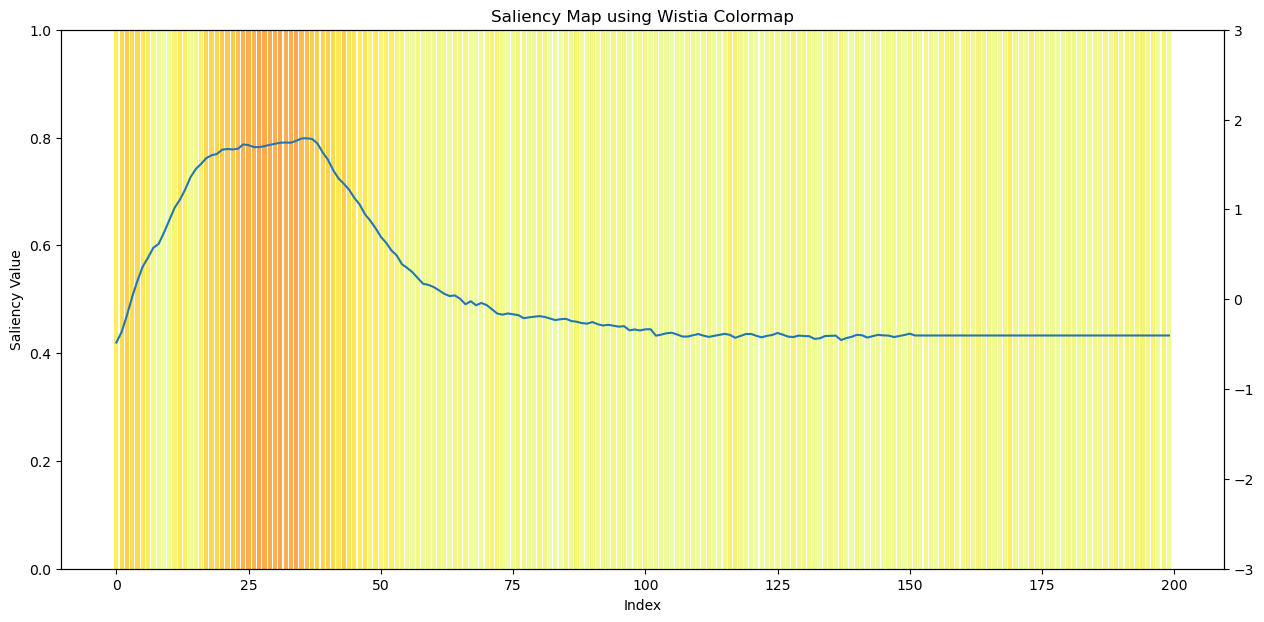

In [99]:
def plot_saliency_map_on_cycles(data, saliency_tuples, index, v_c = 0, show_only_top=False):
    my_data = data[index][:, 0]
    my_saliency_tuples = saliency_tuples[index].tolist()

    saliency_voltage = [item[v_c] for item in my_saliency_tuples]
    saliency_voltage = [(item[0]+item[1])/2 for item in my_saliency_tuples]

    norm = plt.Normalize(min(saliency_voltage), max(saliency_voltage))
    normalized_values = norm(saliency_voltage)
    threshold = np.percentile(saliency_voltage, 90)
    indicator_array = np.where(saliency_voltage > threshold, 1, 0)


    colormap = plt.cm.get_cmap('Wistia')
    fig, ax = plt.subplots()
    # set the plotsize to 20,10
    fig.set_size_inches(15, 7)
    ax2 = ax.twinx()

    bars = ax.bar(np.arange(len(saliency_voltage)), [1] * len(saliency_voltage), color=colormap(normalized_values), alpha=0.7)
    #bars = ax.bar(np.arange(len(saliency_voltage)), indicator_array, color=colormap(normalized_values))

    if show_only_top:
        for (i, bar) in enumerate(bars):
            if indicator_array[i] == 0:
                bar.set_height(0)

    ax.set_ylim(0, 1)
    ax2.set_ylim(-3, 3)
    ax.set_xlabel('Index')
    ax.set_ylabel('Saliency Value')
    ax.set_title('Saliency Map using Wistia Colormap')
    ax2.plot(my_data)
    plt.show()

plot_saliency_map_on_cycles(data_tensor, all_saliency_maps_on_cycles, index=20, v_c=0, show_only_top=False)


# Perturbation of Original Data

In [ ]:
def create_indicator_array(smaps):
    indicator_array = np.empty((len(smaps), 200))
    for i, smap in enumerate(smaps):
        smap_mean = [(item[0]+item[1])/2 for item in smap]
        modified_data = data.clone()
        threshold = np.percentile(smap_mean, 90)
        indicator_array[i] = np.where(smap_mean > threshold, 1, 0)
    return indicator_array

my_indicator_array = create_indicator_array(all_saliency_maps_on_cycles)

In [ ]:
random_saliency = torch.rand((len(data_tensor), 200, 2))

my_random_indicator_array = create_indicator_array(random_saliency)

In [ ]:
def set_high_saliency_to_zero(indicator_array, data):
    modified_data = data.clone()
    for i, data in enumerate(modified_data):
        for j, indicator in enumerate(indicator_array[i]):
            if indicator == 1:
                modified_data[i][j] = torch.tensor((0, 0))
    return modified_data

modified_dataset_90_percent = set_high_saliency_to_zero(my_indicator_array, data_tensor)
modified_dataset_90_percent_r = set_high_saliency_to_zero(my_random_indicator_array, data_tensor)

In [ ]:
def substitute_reverse(indicator_array, data_array, n):

    modified_data_array = data_array.clone()

    for i in range(len(modified_data_array)):
        z = 0
        while z < (len(indicator_array[i])-n):
            if indicator_array[i][z] == 1:
                for j in range(z, min(z + n, len(data_array[i]))):
                    modified_data_array[i][j] = data_array[i][z + n-1 - (j - z)]
                    #print(f"Reversed {modified_data_array[j]}, {j}")
                z += n
            else:
                z += 1

    return modified_data_array

modified_data_reversed = substitute_reverse(my_indicator_array, data_tensor, n=5)
modified_data_reversed_r = substitute_reverse(my_random_indicator_array, data_tensor, n=5)

In [ ]:
plt.plot(modified_data_reversed[200][:,0])
plt.show()
plt.plot(data_tensor[200][:,0])
plt.show()
plt.plot(modified_dataset_90_percent[200][:,0])

In [ ]:
# modified_dataset = TensorDataset(modified_dataset_90_percent, labels_tensor)
# modified_loader = DataLoader(modified_dataset, batch_size=64)
# modified_dataset_random = TensorDataset(modified_dataset_90_percent_r, labels_tensor)
# modified_loader_random = DataLoader(modified_dataset_random, batch_size=64)
# modified_dataset_reversed = TensorDataset(modified_data_reversed, labels_tensor)
# modified_loader_reversed = DataLoader(modified_dataset_reversed, batch_size=64)
# modified_dataset_reversed_random = TensorDataset(modified_data_reversed_r, labels_tensor)
# modified_loader_reversed_random = DataLoader(modified_dataset_reversed_random, batch_size=64)

# trainer.test(mlp_on_cycles, modified_loader_reversed_random)

# Working with Saliency Maps on Embeddings

In [127]:
def plot_saliency_map(all_saliency_maps, index, mode="sum"):
    sm = all_saliency_maps[index]
    #print(sm.shape)
    if mode=="sum":
        sm_summed_or_mean = sm.sum(dim=1, keepdim=True)
        sm_dim_summed_or_mean = sm.sum(dim=0, keepdim=True)
    elif mode=="mean":
        sm_summed_or_mean = sm.mean(dim=1, keepdim=True)
        sm_dim_summed_or_mean = sm.mean(dim=0, keepdim=True)
    #print(sm_summed.shape)
    # Convert the saliency map to an image
    # Display the original image and the saliency map
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(sm, cmap='Wistia')
    plt.title('Saliency Map')
    plt.subplot(1, 3, 2)
    plt.imshow(sm_summed_or_mean, cmap='Wistia')
    if mode=="sum":
        plt.title('Saliency Map Summed')
    elif mode=="mean":
        plt.title('Saliency Map Mean')
    plt.subplot(1, 3, 3)
    plt.imshow(sm_dim_summed_or_mean, cmap='Wistia')
    if mode=="sum":
        plt.title('Saliency Map Dim Summed')
    elif mode=="mean":
        plt.title('Saliency Map Dim Mean')
    plt.xticks([])
    plt.show()
    #print(sm)
    #print(sm_dim_summed)

def plot_multiple_saliency_maps(dim_0_tensor, dim_1_tensor, range=(0,10), mode="sum"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    dim_0 = dim_0_tensor[range[0]:range[1]]
    dim_1 = dim_1_tensor[range[0]:range[1]]
    # Convert the saliency map to an image
    # Display the original image and the saliency map
    ax1.imshow(dim_0, cmap='Wistia')
    if mode=="sum":
        ax1.set_title('Saliency Map Summed')
    elif mode=="mean":
        ax1.set_title('Saliency Map Mean')
    ax2.imshow(dim_1, cmap='Wistia')
    if mode=="sum":
        ax2.set_title('Saliency Map Dims Summed')
    elif mode=="mean":
        ax2.set_title('Saliency Map Dims Mean')

def generate_saliency_map(input_data, target_class):
    input_data.requires_grad = True
    logits = mlp(input_data.unsqueeze(0))
    loss = F.cross_entropy(logits, torch.tensor([target_class]))
    loss.backward()
    saliency_map = input_data.grad.squeeze().abs()
    return saliency_map

def generate_summed_saliency_maps(complete_saliency_tensor, mode="sum"):
    result = torch.empty((len(complete_saliency_tensor), 16))
    for i, sm in enumerate(complete_saliency_tensor):
        if mode=="sum":
            result[i] = sm.sum(dim=1)
        elif mode=="mean":
            result[i] = sm.mean(dim=1)
    #print(summed.shape)

    dim_result = torch.empty((len(complete_saliency_tensor), 2))
    for i, sm in enumerate(complete_saliency_tensor):
        if mode=="sum":
            dim_result[i] = sm.sum(dim=0)
        elif mode=="mean":
            dim_result[i] = sm.mean(dim=0)
    #print(dim_summed.shape)
    return result, dim_result

def plot_sums_or_mean_for_all_data(summed_tensor, dim_summed_tensor, mode="sum"):
    plt.subplot(1, 2, 1)
    plt.title('Saliency Map for the different tuples')
    if mode=="sum":
        complete_summed = summed_tensor.sum(axis=0, keepdim=True)
        complete_dim_summed = dim_summed_tensor.sum(axis=0, keepdim=True)
    elif mode=="mean":
        complete_summed = summed_tensor.mean(axis=0, keepdim=True)
        complete_dim_summed = dim_summed_tensor.mean(axis=0, keepdim=True)
    plt.imshow(complete_summed, cmap='Wistia')
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.title('Saliency Map for the different dimensions of each tuple')
    plt.bar([0,1], complete_dim_summed[0])
    plt.show()
    return complete_summed, complete_dim_summed

def return_dfs_for_embed_position(mean_tensor, id_list, position):
    id_list_p = id_list[:,position]
    saliency_p =mean_tensor[:,position]
    df = pd.DataFrame({"embed_id": id_list_p, "saliency": saliency_p})
    saliency = df.groupby("embed_id").mean().sort_values(by="saliency", ascending=False)
    common = df.groupby("embed_id").count().sort_values(by="saliency", ascending=False)
    common = common.rename(columns={"saliency": "count"})
    most_common = common.join(saliency, on="embed_id").sort_values(by="count", ascending=False)
    highest_saliency = saliency.join(common, on="embed_id").sort_values(by="saliency", ascending=False)
    return most_common, highest_saliency

def get_embed_ids_of_position(s_tensor, position, id_list, amount=5, plot=True):
    
    most_common_embed, highest_saliency_embed = return_dfs_for_embed_position(s_tensor, id_list, position)

    index_common_embeds = torch.tensor(most_common_embed.index[:amount])
    count_common_embeds = torch.tensor(most_common_embed["count"][:amount].values)
    saliency_common_embeds = torch.tensor(most_common_embed["saliency"][:amount].values)
    index_highest_saliency_embeds = torch.tensor(highest_saliency_embed.index[:amount])
    count_highest_saliency_embeds = torch.tensor(highest_saliency_embed["count"][:amount].values)
    saliency_highest_saliency_embeds = torch.tensor(highest_saliency_embed["saliency"][:amount].values)

    if plot:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

        # Plot the bar chart for Frequencies using the first y-axis (ax1)
        ax1.bar(index_common_embeds, count_common_embeds, width=2, color='b', label='Frequencies')
        ax1.set_xlabel('Values')
        ax1.set_ylabel('Frequencies', color='b')
        ax1.set_xlim(-1, 128)
        ax1.set_ylim(0, count_common_embeds.max() + 20)
        ax1.legend(loc='lower right')

        # Plot the bar chart for Average Values using the second y-axis (ax2)
        ax2.bar(index_common_embeds, saliency_common_embeds, width=2, color='y', alpha=0.7, label='Average Gradients')
        ax2.set_xlabel('Values')
        ax2.set_ylabel('Average Gradients', color='y')
        ax2.set_xlim(-1, 128)
        ax2.set_ylim(0, saliency_highest_saliency_embeds.max() + 0.5)
        ax2.legend(loc='lower right')

        ax3.bar(index_highest_saliency_embeds, count_highest_saliency_embeds, width=2, color='g', alpha=0.7, label='Highest Avg. Grad. Freq.')
        ax3.set_xlabel('Values')
        ax3.set_ylabel('Frequencies', color='g')
        ax3.set_xlim(-1, 128)
        ax3.set_ylim(0, count_common_embeds.max() + 20)
        ax3.legend(loc='lower right')

        ax4.bar(index_highest_saliency_embeds, saliency_highest_saliency_embeds, width=2, color='r', alpha=0.7, label='Highest Average Gradients')
        ax4.set_xlabel('Values')
        ax4.set_ylabel('Average Gradients', color='r')
        ax4.set_xlim(-1, 128)
        ax4.set_ylim(0, saliency_highest_saliency_embeds.max() + 0.5)
        ax4.legend(loc='lower right')

        # Adjust the layout to avoid overlap
        #plt.tight_layout()

        # Display the plot
        plt.suptitle(f'Top {amount} Most Common Embeddings and Their Frequencies and Average Gradients | Top {amount} Embeddings with highest average gradients and Their Frequencies and Average Gradients')
        plt.show()

    return index_common_embeds, count_common_embeds, saliency_common_embeds, index_highest_saliency_embeds, count_highest_saliency_embeds, saliency_highest_saliency_embeds, most_common_embed

## DISCLAIMER
Die Data, Label Tensoren müssen noch auf die neue Gesamtmenge angepasst werden

In [110]:
data = np.load("prepared_files/my_complete_q_embeds.npy")
# print(data[0])
labels = np.load("prepared_files/my_complete_label_list.npy")
# print(labels.shape)
embed_ids = np.load("prepared_files/my_complete_id_list.npy")
# print(embed_ids.shape)

In [111]:
data_tensor = torch.tensor(data, dtype=torch.float32)

# all_saliency_maps = torch.empty((len(data_tensor), 16, 2))
# all_saliency_maps_bad = torch.empty((len(data_tensor), 16, 2))
# for i, data in enumerate(data_tensor):
#     all_saliency_maps[i] = generate_saliency_map(data, 1)
#     all_saliency_maps_bad[i] = generate_saliency_map(data, 0)

# np.save("prepared_files/my_saliency_maps.npy", all_saliency_maps.detach().numpy())
# np.save("prepared_files/my_saliency_maps_bad.npy", all_saliency_maps_bad.detach().numpy())


all_saliency_maps = torch.tensor(np.load("prepared_files/my_saliency_maps.npy"))
all_saliency_maps_bad = torch.tensor(np.load("prepared_files/my_saliency_maps_bad.npy"))

In [112]:
all_saliency_maps_summed, all_saliency_maps_dim_summed = generate_summed_saliency_maps(all_saliency_maps)
all_saliency_maps_summed_bad, all_saliency_maps_dim_summed_bad = generate_summed_saliency_maps(all_saliency_maps_bad)
all_saliency_maps_mean, all_saliency_maps_dim_mean = generate_summed_saliency_maps(all_saliency_maps, mode="mean")
all_saliency_maps_mean_bad, all_saliency_maps_dim_mean_bad = generate_summed_saliency_maps(all_saliency_maps_bad, mode="mean")

### Plotten der Saliency Map für eine Instanz von Q-Embeddings

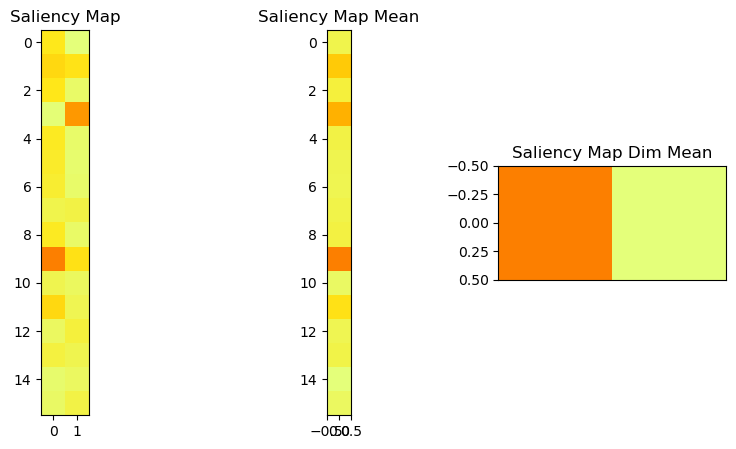

In [113]:
plot_saliency_map(all_saliency_maps, index=0, mode="mean")

### Plotten mehrerer Saliency Maps inklusive Mean für beide Dimensionen

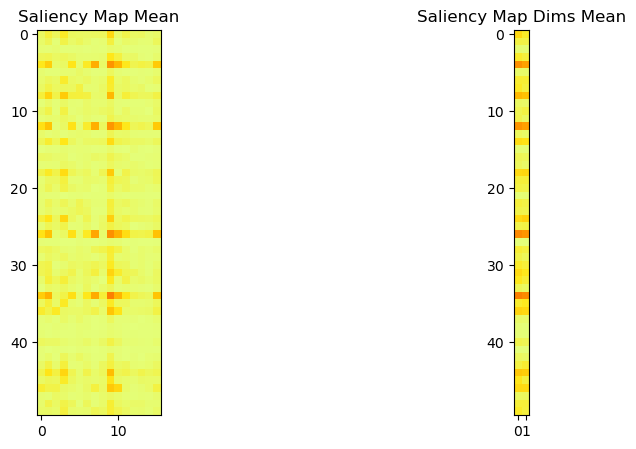

In [125]:
plot_multiple_saliency_maps(all_saliency_maps_mean, all_saliency_maps_dim_mean, (0,50), mode="mean")

### Plotten der Saliency Maps Means für alle Instanzen auf beiden Dimensionen

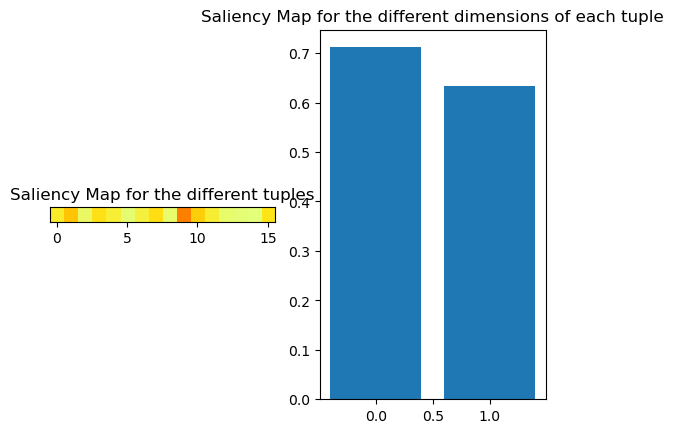

In [115]:
complete_mean, complete_dim_mean = plot_sums_or_mean_for_all_data(all_saliency_maps_mean, all_saliency_maps_dim_mean, mode="mean")

### Das selbe nochmal, Saliency in Bezug auf schlechte Qualität

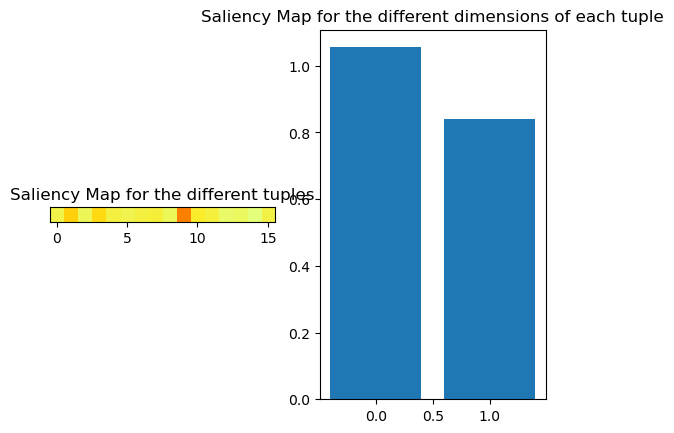

In [116]:
complete_mean_bad, complete_dim_mean_bad = plot_sums_or_mean_for_all_data(all_saliency_maps_mean_bad, all_saliency_maps_dim_mean_bad, mode="mean")

### Die drei Embed-Positionen mit der höchsten Saliency

In [117]:
top_k = 3

print(f"Indices of most relevant embed positions for GOOD: {torch.topk(complete_mean, k=top_k)[1][0]}, Saliency Values: {torch.topk(complete_mean, k=top_k)[0][0]}")
print(f"Indices of most relevant embed positions for BAD: {torch.topk(complete_mean_bad, k=top_k)[1][0]}, Saliency Values: {torch.topk(complete_mean_bad, k=top_k)[0][0]}")

Indices of most relevant embed positions for GOOD: tensor([ 9,  1, 10]), Saliency Values: tensor([2.0352, 1.0698, 0.9782])
Indices of most relevant embed positions for BAD: tensor([9, 1, 3]), Saliency Values: tensor([3.2627, 1.4899, 1.3296])


### Untersuchungen der Saliency einzelner Q-Embeddings aus dem Codebook
Die am häufigsten in den Ergebnissen des Encodes vorkommenden Q-Embeddings sind nicht automatisch die mit der höchsten durchschnittlichen Saliency. Es gibt auch Q-Embeddings, die nur selten vorkommen, aber eine hohe Saliency haben. Diese werden hier auch untersucht.

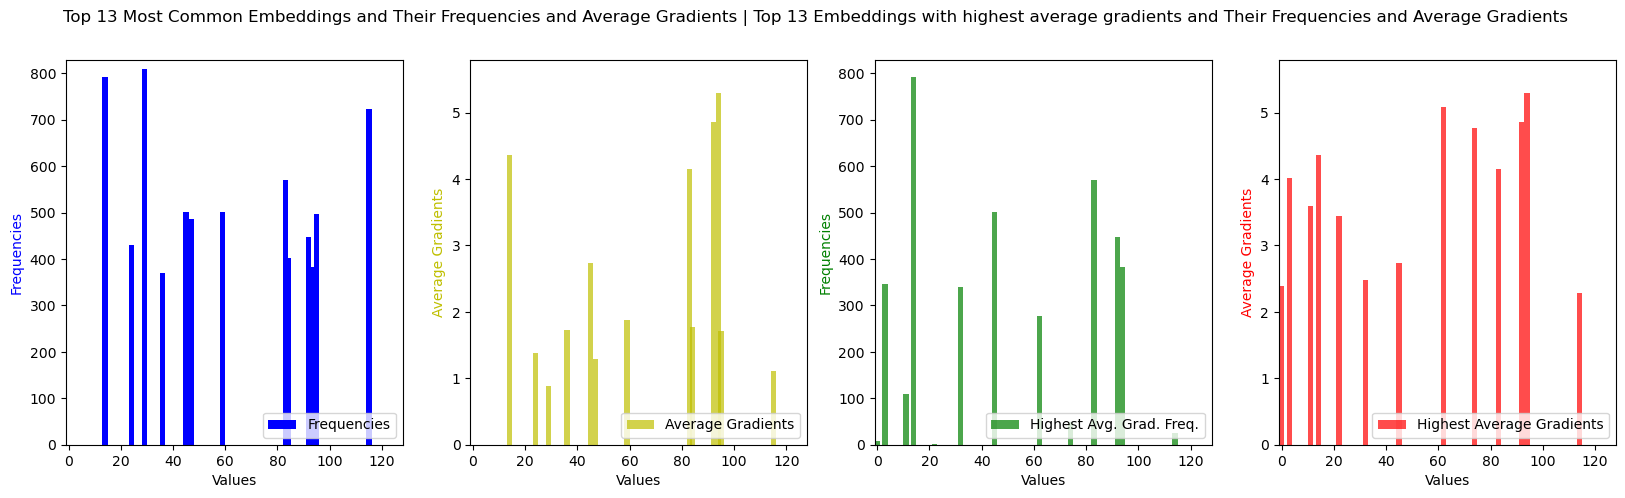

IDs of most common embeddings: tensor([ 29,  14, 115,  83,  45,  59,  95,  47,  92,  24,  84,  94,  36])
Counts of most common embeddings: tensor([809, 792, 722, 570, 502, 501, 497, 485, 448, 429, 402, 382, 369])
Saliency of most common embeddings: tensor([0.8765, 4.3542, 1.1166, 4.1537, 2.7363, 1.8807, 1.7148, 1.2929, 4.8551,
        1.3743, 1.7689, 5.2954, 1.7314])
IDs of highest saliency embeddings: tensor([ 94,  62,  92,  74,  14,  83,   3,  11,  22,  45,  32,   0, 114])
Counts of highest saliency embeddings: tensor([382, 278, 448,  48, 792, 570, 345, 110,   1, 502, 340,   7,  25])
Saliency of highest saliency embeddings: tensor([5.2954, 5.0900, 4.8551, 4.7749, 4.3542, 4.1537, 4.0079, 3.5920, 3.4441,
        2.7363, 2.4746, 2.3839, 2.2843])


In [131]:
ids_common, count_common, saliency_common, id_high_s, count_high_s, saliency_high_s, most_common_embeds = get_embed_ids_of_position(all_saliency_maps_mean, position=9, id_list=embed_ids, amount=13, plot=True)
print(f"IDs of most common embeddings: {ids_common}")
print(f"Counts of most common embeddings: {count_common}")
print(f"Saliency of most common embeddings: {saliency_common}")
print(f"IDs of highest saliency embeddings: {id_high_s}")
print(f"Counts of highest saliency embeddings: {count_high_s}")
print(f"Saliency of highest saliency embeddings: {saliency_high_s}")

### Das selbe wieder für die Saliency Maps in Bezug auf schlechte Qualität

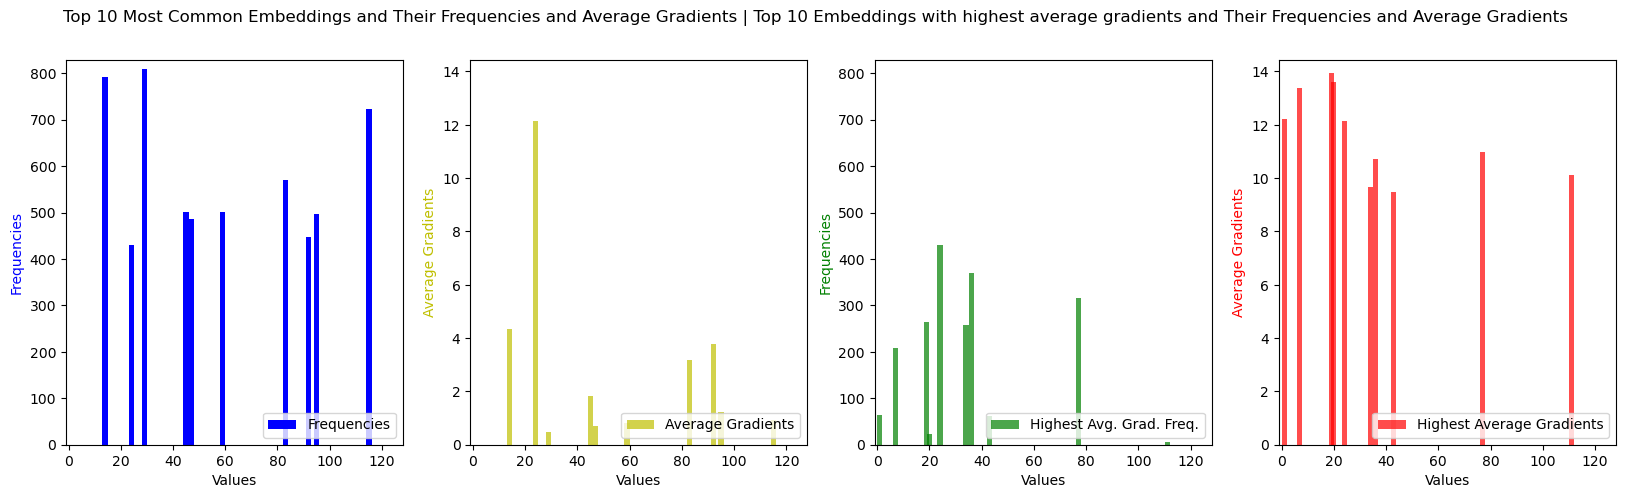

IDs of most common embeddings: tensor([ 29,  14, 115,  83,  45,  59,  95,  47,  92,  24])
Counts of most common embeddings: tensor([809, 792, 722, 570, 502, 501, 497, 485, 448, 429])
Saliency of most common embeddings: tensor([ 0.4647,  4.3234,  0.9192,  3.1684,  1.8427,  0.8124,  1.2414,  0.7152,
         3.7618, 12.1222])
IDs of highest saliency embeddings: tensor([ 19,  20,   7,   1,  24,  77,  36, 111,  34,  43])
Counts of highest saliency embeddings: tensor([264,  24, 208,  63, 429, 316, 369,   6, 257,  62])
Saliency of highest saliency embeddings: tensor([13.9378, 13.6159, 13.3792, 12.2163, 12.1222, 10.9889, 10.7273, 10.1215,
         9.6549,  9.4598])


In [126]:
ids_common, count_common, saliency_common, id_high_s, count_high_s, saliency_high_s = get_embed_ids_of_position(all_saliency_maps_mean_bad, position=9, id_list=embed_ids, amount=10, plot=True)
print(f"IDs of most common embeddings: {ids_common}")
print(f"Counts of most common embeddings: {count_common}")
print(f"Saliency of most common embeddings: {saliency_common}")
print(f"IDs of highest saliency embeddings: {id_high_s}")
print(f"Counts of highest saliency embeddings: {count_high_s}")
print(f"Saliency of highest saliency embeddings: {saliency_high_s}")

### Untersuchen, ob  die Saliency Werte in Zusammenhang mit den Labels stehen

In [133]:
mean_sal_of_data = all_saliency_maps_mean.mean(axis=1, keepdim=True)
mean_sal_of_data = torch.reshape(mean_sal_of_data, (len(mean_sal_of_data),))
lowest_values, lowest_indices = torch.topk(mean_sal_of_data, k=10, largest=False)
highest_values, highest_indices = torch.topk(mean_sal_of_data, k=10, largest=True)

mean_sal_of_data_bad = all_saliency_maps_mean_bad.mean(axis=1, keepdim=True)
mean_sal_of_data_bad = torch.reshape(mean_sal_of_data_bad, (len(mean_sal_of_data_bad),))
lowest_values_bad, lowest_indices_bad = torch.topk(mean_sal_of_data_bad, k=10, largest=False)
highest_values_bad, highest_indices_bad = torch.topk(mean_sal_of_data_bad, k=10, largest=True)
print(lowest_indices)
print(lowest_values)
print(highest_indices)
print(highest_values)

tensor([ 6462, 14204,  5390,  9454, 11836, 15328,  2855,  1277, 15808,  3874])
tensor([0.0139, 0.0151, 0.0180, 0.0185, 0.0197, 0.0204, 0.0206, 0.0207, 0.0211,
        0.0215])
tensor([ 7211,  9029,  2822,  2725, 13437, 15341,  4170,  1602,  3637, 12767])
tensor([3.1360, 3.0011, 2.9782, 2.9123, 2.8980, 2.8857, 2.8823, 2.8774, 2.8686,
        2.8677])


In [135]:
# Time series with the highest or lowest mean gradients (GOOD Classification)
low_saliency_data = data_tensor[lowest_indices]
low_saliency_labels = labels_tensor[lowest_indices]
high_saliency_data = data_tensor[highest_indices]
high_saliency_labels = labels_tensor[highest_indices]

# Time series with the highest or lowest mean gradients (BAD Classification)
low_saliency_data_bad = data_tensor[lowest_indices_bad]
low_saliency_labels_bad = labels_tensor[lowest_indices_bad]
high_saliency_data_bad = data_tensor[highest_indices_bad]
high_saliency_labels_bad = labels_tensor[highest_indices_bad]

print(f"Labels of lowest saliency data for GOOD Classification: {low_saliency_labels}")
print(f"Labels of highest saliency data for GOOD Classification: {high_saliency_labels}")
print("\n")
print(f"Labels of lowest saliency data for BAD Classification: {low_saliency_labels_bad}")
print(f"Labels of highest saliency data for BAD Classification: {high_saliency_labels_bad}")

print(low_saliency_data.shape)
print(low_saliency_labels.shape)

Labels of lowest saliency data for GOOD Classification: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Labels of highest saliency data for GOOD Classification: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])


Labels of lowest saliency data for BAD Classification: tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 0])
Labels of highest saliency data for BAD Classification: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1])
torch.Size([10, 16, 2])
torch.Size([10])


In [136]:
def print_results_from_mlp(mlp, low_saliency_data, low_saliency_labels):
    preds, loss, acc, acc_good, acc_bad, f1score = mlp._get_preds_loss_accuracy((low_saliency_data, low_saliency_labels))     
    print(f"Preds: {preds}")
    print(f"Actual Labels: {low_saliency_labels}")
    print(f"Loss: {loss}")
    print(f"Accuracy: {acc}")
    print(f"Accuracy for GOOD: {acc_good}")
    print(f"Accuracy for BAD: {acc_bad}")
    print(f"F1 Score: {f1score}")

print("LOW SALIENCY DATA FOR GOOD CLASSIFICATION")
print_results_from_mlp(mlp, low_saliency_data, low_saliency_labels)
print("\n")
print("HIGH SALIENCY DATA FOR GOOD CLASSIFICATION")
print_results_from_mlp(mlp, high_saliency_data, high_saliency_labels)
print("\n")
print("LOW SALIENCY DATA FOR BAD CLASSIFICATION")
print_results_from_mlp(mlp, low_saliency_data_bad, low_saliency_labels_bad)
print("\n")
print("HIGH SALIENCY DATA FOR BAD CLASSIFICATION")
print_results_from_mlp(mlp, high_saliency_data_bad, high_saliency_labels_bad)


LOW SALIENCY DATA FOR GOOD CLASSIFICATION
Preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Actual Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Loss: 0.006375201977789402
Accuracy: 1.0
Accuracy for GOOD: 1.0
Accuracy for BAD: 0
F1 Score: 1.0


HIGH SALIENCY DATA FOR GOOD CLASSIFICATION
Preds: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Actual Labels: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
Loss: 0.2584185004234314
Accuracy: 0.8999999761581421
Accuracy for GOOD: 0.0
Accuracy for BAD: 1.0
F1 Score: 0.0


LOW SALIENCY DATA FOR BAD CLASSIFICATION
Preds: tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0])
Actual Labels: tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 0])
Loss: 0.6931034326553345
Accuracy: 0.4000000059604645
Accuracy for GOOD: 0.20000000298023224
Accuracy for BAD: 0.6000000238418579
F1 Score: 0.25


HIGH SALIENCY DATA FOR BAD CLASSIFICATION
Preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Actual Labels: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1])
Loss: 0.3485139012336731
Accuracy: 0.8999999761581421
Accuracy for GOO

### Einsetzen eigener Q-Embeddings in den VQ-VAE Decoder, um die Rekonstruktion zu untersuchen

In [12]:
from model.vector_quantizer import VectorQuantizer
from model.vq_vae import VectorQuantizedVAE

import os

def get_model(model_name: str):
    model_path = f"./artifacts/{model_name}/model.ckpt"
    if os.path.exists(model_path):
        model_name = 'VQ VAE'
        print("model exists, no download needed")
    else:
        print("model missing")
        return None, None
    #model_name, model_path = get_pretrained_vqvae_models("vq_vae_model")
    vq_vae_dict = torch.load(model_path, map_location=torch.device('cpu'))
    print(vq_vae_dict['hyper_parameters'])
    vq_vae_dict['hyper_parameters'].pop('wandb_logger')
    model = VectorQuantizedVAE(**vq_vae_dict['hyper_parameters'])
    model.load_state_dict(vq_vae_dict['state_dict'])

    return model, vq_vae_dict['hyper_parameters']

model, hparams = get_model("vq_vae_model")
# print(hparams)
model.eval()

model missing


AttributeError: 'NoneType' object has no attribute 'eval'